### Solving JSP with Google OR Tools

In [6]:
!pip install ortools
!pip install pandas
!pip install matplotlib
import ortools
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot

### Generating JSP Problem instances

In [2]:
import random

def generate_jobs(num_of_jobs: int, num_of_machines: int):
    '''
    generate_jobs return the job data and lower bound

    job_data: [
        (machine_id, op_duration)...
    ]

    lower_bound: sum of all op_duration
    '''
    jobs = [[] for i in range(num_of_jobs)]

    for i in range(num_of_jobs):
        available_machine_ids = [(x) for x in range(num_of_machines)]
        for j in range(num_of_machines):
            operation_duration = random.randint(1, 99)
            machine_id = random.choice(available_machine_ids)
            available_machine_ids.remove(machine_id)
            jobs[i].append((machine_id, operation_duration))

    lower_bound = sum(task[1] for job in jobs for task in job)
    return jobs, lower_bound

### JSP Solver using Google OR Tools

In [10]:
import collections

from ortools.sat.python import cp_model

def solve(jobs, lower_bound: int):
    assert len(jobs) > 0, "Jobs should contain at least one job"

    NUM_OF_MACHINES = len(jobs[0])

    model = cp_model.CpModel()
    all_machines = range(NUM_OF_MACHINES)

    task_type = collections.namedtuple('task_type', 'start end interval')
    assigned_task_type = collections.namedtuple('assigned_task_type', 'start job index duration')

    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    # Machine sequences
    for job_id, job in enumerate(jobs):
        for task_id, task in enumerate(job):
            machine = task[0]
            duration = task[1]
            suffix = f'_{job_id}_{task_id}'
            start_var = model.NewIntVar(0, lower_bound, 'start' + suffix)
            end_var = model.NewIntVar(0, lower_bound, 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var, 'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(start=start_var, end=end_var, interval=interval_var)
            machine_to_intervals[machine].append(interval_var)

    # No overlapping operation constraint
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Operation precedence constraint
    for job_id, job in enumerate(jobs):
        for task_id in range(len(job) - 1):
            model.Add(all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end)

    # Objective: Minimize Makespan
    obj_var = model.NewIntVar(0, lower_bound, 'makespan')
    model.AddMaxEquality(obj_var, [
        all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs)
    ])
    model.Minimize(obj_var)

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    schedules = []
    if status == cp_model.OPTIMAL or cp_model.FEASIBLE:
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobs):
            for task_id, task in enumerate(job):    
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(
                        start=solver.Value(all_tasks[job_id, task_id].start),
                        job=job_id,
                        index=task_id,
                        duration=task[1]
                    ))

    results = []
    schedule_length = solver.ObjectiveValue()
    for machine in all_machines:
        for assigned_task in assigned_jobs[machine]:
            results.append({
                'Job': assigned_task.job + 1,
                'Machine': machine + 1,
                'Start': assigned_task.start,
                'Duration': assigned_task.duration,
                'Finish': assigned_task.start + assigned_task.duration,
            })      

    return results, schedule_length

### Visualize schedule

In [7]:
def visualize_schedule(results, save_file=False):
    '''
    visualize_schedule takes in the schedule and display the schedule in a Gantt chart
    The chart can also be saved as a PNG file if save_file is passed True
    The file will be saved as "schedule.png"

    Parameters:

    results (dict): a list of dicts in following format -
    Each dict represent one scheduled operation
    [
        {
            'Job':      <job_id>,
            'Machine':  <machine_id>,
            'Start':    <time_unit the operation starts>,
            'Duration': <duration of the operation>,
            'Finish':   <time_unit the operation ends>,
        },
        ...
    ]

    save_file (boolean): If save_file is true, the chart will be saved as 'schedule.png'
    '''

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':30, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = matplotlib.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = matplotlib.pyplot.subplots(2,1, figsize=(16, 12+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()
    if save_file:
        matplotlib.pyplot.savefig("schedule.png")
    else:
        matplotlib.pyplot.show()

### Solving JSP

4917
[{'Job': 1, 'Machine': 1, 'Start': 558, 'Duration': 62, 'Finish': 620}, {'Job': 2, 'Machine': 1, 'Start': 758, 'Duration': 34, 'Finish': 792}, {'Job': 3, 'Machine': 1, 'Start': 60, 'Duration': 9, 'Finish': 69}, {'Job': 4, 'Machine': 1, 'Start': 702, 'Duration': 56, 'Finish': 758}, {'Job': 5, 'Machine': 1, 'Start': 792, 'Duration': 7, 'Finish': 799}, {'Job': 6, 'Machine': 1, 'Start': 454, 'Duration': 2, 'Finish': 456}, {'Job': 7, 'Machine': 1, 'Start': 620, 'Duration': 82, 'Finish': 702}, {'Job': 8, 'Machine': 1, 'Start': 400, 'Duration': 9, 'Finish': 409}, {'Job': 9, 'Machine': 1, 'Start': 71, 'Duration': 99, 'Finish': 170}, {'Job': 10, 'Machine': 1, 'Start': 179, 'Duration': 85, 'Finish': 264}, {'Job': 1, 'Machine': 2, 'Start': 0, 'Duration': 9, 'Finish': 9}, {'Job': 2, 'Machine': 2, 'Start': 453, 'Duration': 25, 'Finish': 478}, {'Job': 3, 'Machine': 2, 'Start': 108, 'Duration': 98, 'Finish': 206}, {'Job': 4, 'Machine': 2, 'Start': 563, 'Duration': 11, 'Finish': 574}, {'Job': 5, 

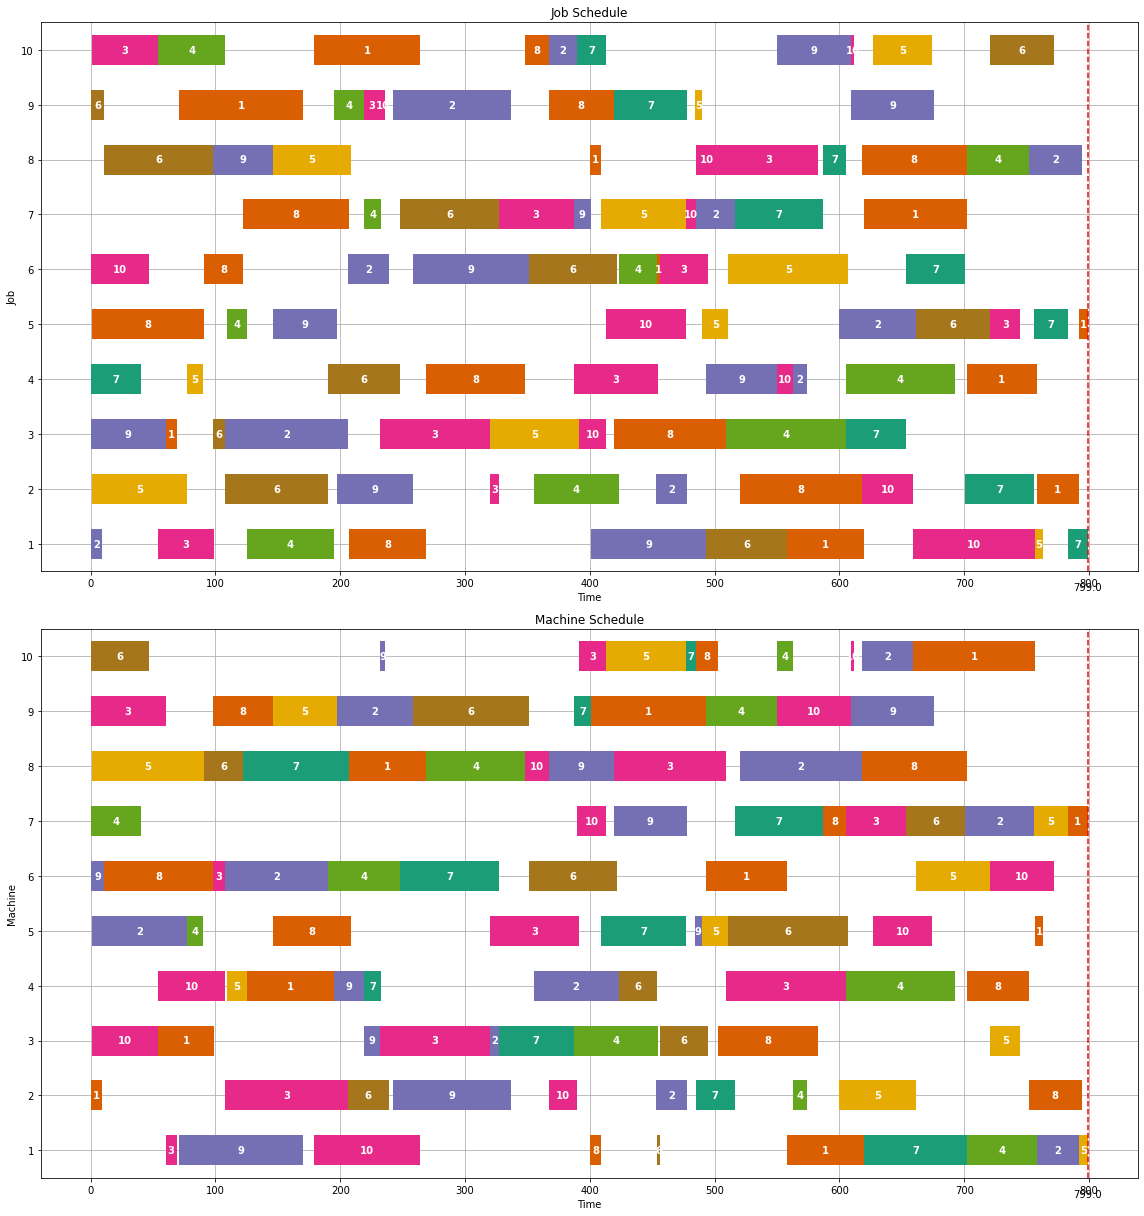

In [11]:
NUM_OF_JOBS = 10
NUM_OF_MACHINES = 10

jobs, lower_bound = generate_jobs(NUM_OF_JOBS, NUM_OF_MACHINES)

schedule, schedule_length = solve(jobs, lower_bound)

print(lower_bound)
print(schedule)
print(schedule_length)
visualize_schedule(schedule)